In [1]:
import os
import gc
import numpy as np
import pandas as pd

import ast
import re, string
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

/home/kranthi/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/kranthi/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def get_data():
    train = pd.read_csv("../data/v2/train_ne.csv")
    test = pd.read_csv("../data/test_ne_imputed.csv")
    print("Train Shape : {}\nTest Shape :  {}".format(train.shape, test.shape))
    
    train = train[['fold_id', 'title', 'description', 'text', 'category', 'source']]
    test = test[['title', 'description', 'text', 'category']]
    train.dropna(inplace=True)
    
    return train, test

In [3]:
train, test = get_data()
train.head()

Train Shape : (1199998, 6)
Test Shape :  (92, 5)


,fold_id,title,description,text,category,source
0,1,ziczac black red euro 44,clothing related products b2c shoes shoe laces,ziczac black red euro 44 clothing related prod...,R,valid
1,1,9x9 resista 484938,publishing printing printing services,9x9 resista 484938 publishing printing printin...,S,train
2,1,halle pant short inseam 013049561d0010001 02,clothing related products b2c general,halle pant short inseam 013049561d0010001 02 c...,R,train
3,1,harry houser travel expenses meals,security personnel,harry houser travel expenses meals security pe...,S,train
4,1,tee time 740078609 greens fee composite,admissions green fees privately owned golf course,tee time 740078609 greens fee composite admiss...,R,valid


In [4]:
K = 6

#### LabelEncoding Target

In [5]:
target = 'category'

le = LabelEncoder()
train[target] = le.fit_transform(train[target].values)
test[target] = le.transform(test[target].values)

y = train[target].values
y_test = test[target].values

print(le.classes_)

['R' 'S']


### Splitter

In [6]:
def splitter(data, k=K):
    
    data_v1 = data[data['fold_id'] == k].copy()
    data_v1.reset_index(drop=True, inplace=True)
    
    train_set = data_v1[data_v1['source'] == 'train'].copy()
    valid_set = data_v1[data_v1['source'] == 'valid'].copy()
    train_set.reset_index(drop=True, inplace=True)
    valid_set.reset_index(drop=True, inplace=True)
    
    del data_v1
    gc.collect()
    
#     print(train_set.shape, valid_set.shape)
    
    return train_set['text'].values, valid_set['text'].values, train_set['category'].values, valid_set['category'].values

### Baseliner Function to evaluate : 

In [7]:
def eval_t(y_pred):
    return f1_score(y_test, y_pred)

def baseliner(X_train, X_valid, y_train, y_valid, X_test, cv=3, metric='f1'):
    print("Baseliner Models\n")
    eval_dict = {}
    models = [LogisticRegression(), GaussianNB(), lgb.LGBMClassifier(), RandomForestClassifier(),
              DecisionTreeClassifier(), ExtraTreeClassifier()
             ]
    # xgb.XGBClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(), BaggingClassifier(), ExtraTreesClassifier() 
    print("Model Name \t | Train \t | Valid \t | Test ") #    | \t TRN   | \t  VAL
    print("--" * 30)
    
    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}
        
        model.fit(X_train, y_train)
        train_f1 = f1_score(y_train, model.predict(X_train))
        valid_f1 = f1_score(y_valid, model.predict(X_valid))
        test_f1 = eval_t(model.predict(X_test))
        
        eval_dict[model_name]['train'] = train_f1
        eval_dict[model_name]['valid'] = valid_f1
        eval_dict[model_name]['test'] = test_f1
        
        print("%s \t | %.4f \t | %.4f \t | %.4f \t " % (
            model_name[:12], eval_dict[model_name]['train'], eval_dict[model_name]['valid'], eval_dict[model_name]['test']))

### Using only frequency based methods to model : 

1. CountVectorizer
2. Tf-IdfVectorizer

In [8]:
def tokenize(s): 
    return s.split()

In [9]:
def fit_and_return_vectorizer(train, test, vectorizer, text_col='text', subsample_train=False):

    total_texts = pd.concat([train[text_col], test[text_col]], axis=0)
    total_texts.reset_index(drop=True, inplace=True)

    vectorizer.fit(total_texts.values)
    if subsample_train:
#         k = np.random.choice(train['fold_id'].unique())
        print(f"Choosing Random Subsample Fold-ID : {K}")
        X_train, X_valid, y_train, y_valid = splitter(train)

    train_count_vect = vectorizer.transform(X_train)
    valid_count_vect = vectorizer.transform(X_valid)
    test_count_vect = vectorizer.transform(test[text_col].values)

    print("Number of features / words in vocab : {}".format(len(vectorizer.get_feature_names())))
    print("Transformed Shapes :: \nTrain : {}\nValid : {}\nTest :  {}".format(
        train_count_vect.shape, valid_count_vect.shape, test_count_vect.shape))
    
    del total_texts
    gc.collect()
    
    return vectorizer, train_count_vect, valid_count_vect, test_count_vect, y_train, y_valid

### CountVectorizer

In [10]:
%%time

max_features = 1_000
vect = CountVectorizer(max_features=max_features)
vect, transformed_train, transformed_valid, transformed_test, y_new_train, y_new_valid = fit_and_return_vectorizer(
    train, test, vect, subsample_train=True)

Choosing Random Subsample Fold-ID : 6
Number of features / words in vocab : 1000
Transformed Shapes :: 
Train : (99372, 1000)
Valid : (20592, 1000)
Test :  (92, 1000)
CPU times: user 36.4 s, sys: 504 ms, total: 36.9 s
Wall time: 36.9 s


In [13]:
baseliner(transformed_train.toarray(), transformed_valid.toarray(), y_new_train, y_new_valid, transformed_test.toarray())

## Before Validation Strategy
# Model Name     |    CV     | Test 
# ------------------------------------------------------------
# LogisticRegr 	 | 0.9992 	 | 0.8846 	 
# GaussianNB 	 | 0.9807 	 | 0.9159 	 
# LGBMClassifi 	 | 0.9993 	 | 0.8738 	 
# RandomForest 	 | 0.9993 	 | 0.9038 	 
# DecisionTree 	 | 0.9972 	 | 0.8077 	 
# ExtraTreeCla 	 | 0.9971 	 | 0.7500 	 

Baseliner Models

Model Name 	 | Train 	 | Valid 	 | Test 
------------------------------------------------------------
LogisticRegr 	 | 0.9996 	 | 0.9731 	 | 0.8846 	 
GaussianNB 	 | 0.9794 	 | 0.9757 	 | 0.9358 	 
LGBMClassifi 	 | 0.9999 	 | 0.9637 	 | 0.8713 	 
RandomForest 	 | 0.9999 	 | 0.9621 	 | 0.8491 	 
DecisionTree 	 | 0.9999 	 | 0.9321 	 | 0.7890 	 
ExtraTreeCla 	 | 0.9999 	 | 0.8694 	 | 0.7963 	 


### Boosting Utilities

In [14]:
threshold = 0.5

def f1_lgb(y_hat, data):
    y_true = data.get_label()
    y_hat[y_hat < threshold] = 0
    y_hat[y_hat >= threshold] = 1
    
    return 'f1_score', f1_score(y_true, y_hat), True

def f1_xgb(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred[y_pred < threshold] = 0
    y_pred[y_pred >= threshold] = 1
    
    return 'f1_score', f1_score(y_true, y_pred)

def lgb_model(trainX, validX, trainY, validY, X_test):
    evals_result = {}
    print("LGB Model")
    lgb_train_set = lgb.Dataset(trainX, label=trainY)
    lgb_valid_set = lgb.Dataset(validX, label=validY)

    MAX_ROUNDS = 2000
    lgb_params = {
        "boosting": 'gbdt',  # "dart",
        "learning_rate": 0.01,
        "nthread": -1,
        "seed": 13,
        "num_boost_round": MAX_ROUNDS,
        "objective": "binary",
    }

    lgb_model = lgb.train(
        lgb_params,
        train_set=lgb_train_set,
        valid_sets=[lgb_train_set, lgb_valid_set],
        early_stopping_rounds=50,
        verbose_eval=100,
        evals_result=evals_result,
        feval=f1_lgb
    )

    lgb.plot_importance(lgb_model, figsize=(24, 24))
    lgb.plot_metric(evals_result, metric='f1_score')
    
    preds = lgb_model.predict(X_test)
    preds[preds >= threshold] = 1
    preds[preds < threshold] = 0
    
    test_f1 = eval_t(preds)
    print("Test Score : {}".format(test_f1))
    
    return lgb_model

def xgb_model(X_train, X_valid, y_train, y_valid, X_test):

    MAX_ROUNDS=2000
    early_stopping_rounds=50
    params = {
        'booster': 'gbtree', # dart
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'learning_rate': 0.1,
        'num_round': MAX_ROUNDS,
        'max_depth': 8,
        'seed': 13,
        'nthread': -1
    }
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

    model = xgb.train(
        params,
        dtrain,
        evals=watchlist,
        num_boost_round=MAX_ROUNDS,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=50,
        feval=f1_xgb,
        maximize=True
    )
    print("Best Iteration :: ", model.best_iteration)

    # Plotting Importances
    fig, ax = plt.subplots(figsize=(24, 24))
    xgb.plot_importance(model, height=0.4, ax=ax)
    preds = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
    preds[preds >= threshold] = 1
    preds[preds < threshold] = 0
    
    test_f1 = eval_t(preds)
    print("Test Score : {}".format(test_f1))
    
    return model

def feature_order(feat, model):
    feat_imp = pd.DataFrame(model.feature_importances_, index=feat)
    feat_imp.reset_index(inplace=True)
    feat_imp.columns = ['columns', 'importance']

    feat_imp = feat_imp.iloc[feat_imp['importance'].sort_values(ascending=False).index]

    return feat_imp, feat_imp['columns'].values.tolist()

LGB Model
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.504806	training's f1_score: 0.992783	valid_1's binary_logloss: 0.504851	valid_1's f1_score: 0.99279
Test Score : 0.7050359712230214


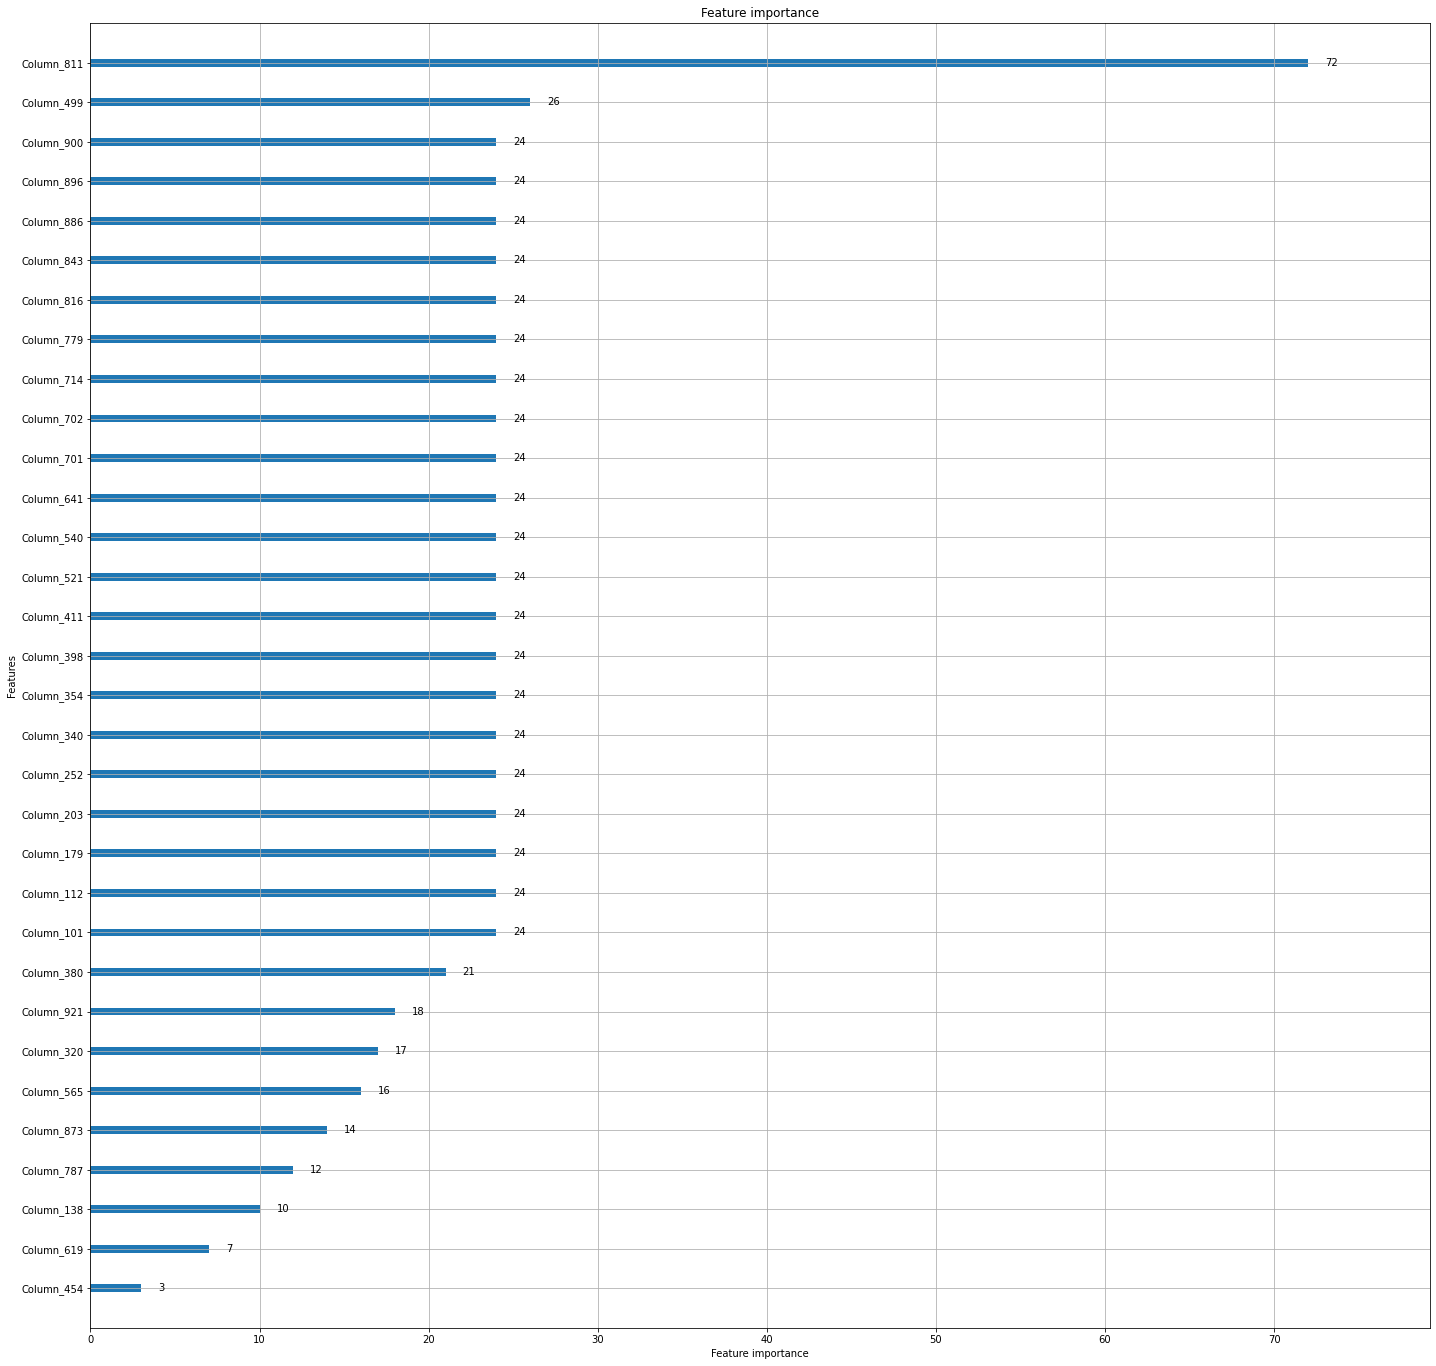

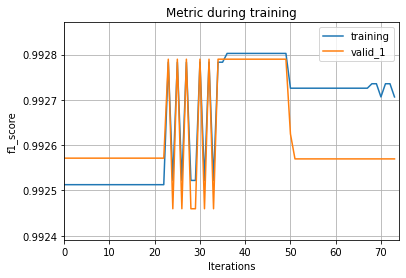

In [16]:
lgbM = lgb_model(transformed_train.toarray(), transformed_test.toarray(), y_new)

In [17]:
# xgbM = xgb_model(transformed_train.toarray(), transformed_test.toarray(), y_new)

### TF-IDF

In [15]:
%%time

max_features = 1_000
vect = TfidfVectorizer(max_features=max_features)
vect, transformed_train, transformed_valid, transformed_test, y_new_train, y_new_valid = fit_and_return_vectorizer(
    train, test, vect, subsample_train=True)

Choosing Random Subsample Fold-ID : 6
Number of features / words in vocab : 1000
Transformed Shapes :: 
Train : (99372, 1000)
Valid : (20592, 1000)
Test :  (92, 1000)
CPU times: user 33.6 s, sys: 424 ms, total: 34 s
Wall time: 34 s


In [16]:
baseliner(transformed_train.toarray(), transformed_valid.toarray(), y_new_train, y_new_valid, transformed_test.toarray())

Baseliner Models

Model Name 	 | Train 	 | Valid 	 | Test 
------------------------------------------------------------
LogisticRegr 	 | 0.9988 	 | 0.9723 	 | 0.9057 	 
GaussianNB 	 | 0.9807 	 | 0.9618 	 | 0.9358 	 
LGBMClassifi 	 | 0.9999 	 | 0.9505 	 | 0.8515 	 
RandomForest 	 | 0.9999 	 | 0.9702 	 | 0.8485 	 
DecisionTree 	 | 0.9999 	 | 0.9364 	 | 0.8247 	 
ExtraTreeCla 	 | 0.9999 	 | 0.8981 	 | 0.7917 	 


In [17]:
# lgbM = lgb_model(transformed_train.toarray(), transformed_valid.toarray(), y_new_train, y_new_valid, transformed_test.toarray())

In [18]:
# xgbM = xgb_model(transformed_train.toarray(), transformed_valid.toarray(), y_new_train, y_new_valid, transformed_test.toarray())

## Evaluation

### CountVect vs TF-IDF 

Even though TF-IDF is theoratically a better and intuitive model than naive CountVect we can see that the evaluation for both of them are very comparable and very near.

Some of the best model : 

1. Naive Bayes : 93.58%
1. LogisticReg : 90.57%
1. LightGBM : 87.13%

I haven't used other boosting models such as XGB and Catboost as they are very compute-heavy models and choosed lightgbm because it's faster and easier for baselining.

### Confusion Matrix + Understanding Evaluation

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

def plot_classification_report(model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)
    T = 0.44
    preds = model.predict_proba(X_test)[:, 1]
    pred_probs = preds.copy()
    preds[preds >= T] = 1
    preds[preds < T] = 0
    
    cm = confusion_matrix(y_test, preds)
    print("Classification Report")
    print(classification_report(y_test, preds))
    class_names = ["R", "S"]  # name  of classes

    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu", fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return pred_probs

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        35
           1       0.98      0.89      0.94        57

    accuracy                           0.92        92
   macro avg       0.92      0.93      0.92        92
weighted avg       0.93      0.92      0.92        92



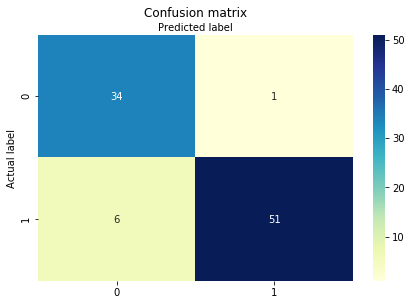

In [20]:
pred_probs = plot_classification_report(GaussianNB(), transformed_train.toarray(), transformed_test.toarray(), y_new_train, y_test)

It seems we have higher False Negatives i.e 6 predictions which are actually Positive which have been faslely classified as Negative.

### Plotting the prediction probability distribution

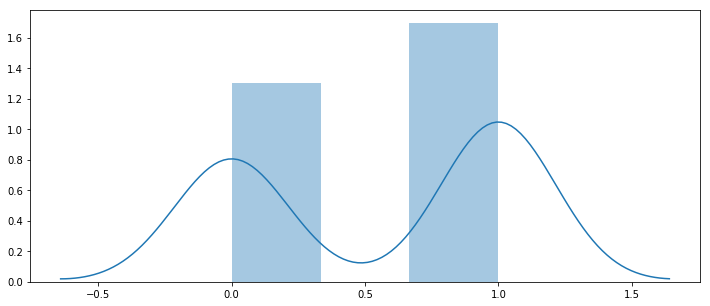

In [21]:
plt.figure(figsize=(12, 5))
sns.distplot(pred_probs)
plt.show()

### Does ensembling help?

In [22]:
good_models = {
    "gaussian_nb": GaussianNB(),
    "log_reg" : LogisticRegression(),
    "lgb" : lgb.LGBMClassifier(),
}

soft_preds = {}
hard_preds = {}

for model_name, model in good_models.items():
    
    print("Model : {}".format(model_name))
    hard_preds[model_name] = np.nan
    soft_preds[model_name] = np.nan
    
    model.fit(transformed_train.toarray(), y_new_train)
    train_score = f1_score(y_new_train, model.predict(transformed_train.toarray()))
    preds = model.predict(transformed_test.toarray())
    pred_probs = model.predict_proba(transformed_test.toarray())[:, 1]
    
    hard_preds[model_name] = preds
    soft_preds[model_name] = pred_probs
    
    test_score = eval_t(preds)
    print("Train Score : {:.4f}\nTest Score : {:.4f}".format(train_score, test_score))

Model : gaussian_nb
Train Score : 0.9807
Test Score : 0.9358
Model : log_reg
Train Score : 0.9988
Test Score : 0.9057
Model : lgb
Train Score : 0.9999
Test Score : 0.8515


In [18]:
# 1. Hard Voting : 
zip_ = zip(hard_preds['gaussian_nb'], hard_preds['log_reg'], hard_preds['lgb'])
preds = []
for i, j, k in zip_:
    lst = [i, j, k]
    preds.append(max(set(lst), key=lst.count))
    
print(f"Hard Voting F1 : {eval_t(preds)}")

Hard Voting F1 : 0.9245283018867925


#### Choosing best threshold for good F1

In [26]:
def tweak_threshold(pred, truth):
    thresholds = []
    scores = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        thresholds.append(thresh)
        score = f1_score(truth, (pred>thresh).astype(int))
        scores.append(score)
#     print(scores)
    return np.max(scores), thresholds[np.argmax(scores)]

In [20]:
# 2. Soft-Voting
# Finding the best threshold for best F1-Score : 

ens_1 = (soft_preds['gaussian_nb'] + soft_preds['log_reg'] + soft_preds['lgb'])/3

# First getting the threshold value from train_predictions
score_val, threshold_val = tweak_threshold(model.predict_proba(transformed_train.toarray())[:, 1], y_new)
print(f"Scored {round(score_val, 4)} for threshold {threshold_val} on train data")

# Then getting the f1 score in test set using that threshold
ens_1[ens_1 >= threshold_val] = 1
ens_1[ens_1 < threshold_val] = 0

print(f"Scored {round(eval_t(ens_1), 4)} for threshold {threshold_val} on test data")

Scored 0.9999 for threshold 0.41 on train data
Scored 0.9444 for threshold 0.41 on test data


### Saving the predictions for further ensembling

In [21]:
sub = pd.DataFrame()
sub['gnb'] = soft_preds['gaussian_nb']
sub['log_reg'] = soft_preds['log_reg']
sub['lgb'] = soft_preds['lgb']
sub['avg_3'] = (soft_preds['gaussian_nb'] + soft_preds['log_reg'] + soft_preds['lgb'])/3

In [22]:
sub.to_csv("../subs/frequency_models.csv", index=False)

## Conclusion 


### Single : Naive Bayes worked best : 0.9358

### 3 Model Ensemble :  0.9444 (NB + LR + LGB)